# Photometry

Photometry lab part  2:
This notebook is for the photometry part of the photometry lab. Data used is form the observing project. 

__Q8: What drawbacks could exist from this method of sky subtraction?__  
Aperture photometry forces you to draw a circle around an area that you assume most of the flux from your object falls within. This means that you miss some of the flux from your object distributed on the outsides of that circle. Aperture photometry is a biased and inconsistent estimator meaning that for an infinite number of observations, the flux measured asymptote to a value lower than the true value. These effects can be removed using aperture correction, or by using the same size aperature for calibration stars and science objects however this assumes that the PSF from these objects is the same.  

__Q9: Why does sky subtraction matter?__  

We have to subtract the sky because there is diffuse light coming from other objects that is incident on the entire CCD. This is a source of noise and therefore has to be removed from the calculation of the flux from the object of interest. 

In [117]:
import numpy as np
from photutils import datasets
from astropy.io import fits
from astropy.io import ascii
import glob
import matplotlib.pyplot as plt


In [183]:
# Load in the data from one of the objects
images = glob.glob('data/CrabData/reduced/reduced2*.fits')

data = fits.getdata(images[5]).astype(float)

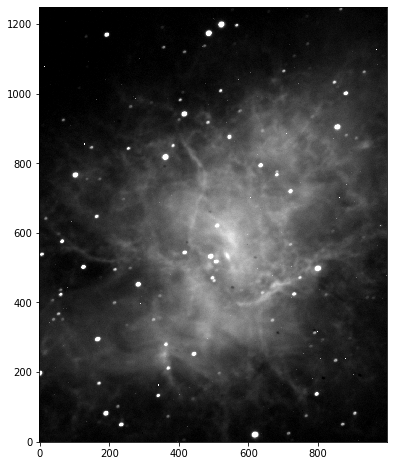

In [184]:
# Make a function to plot the image

def showImage(data, vMin = 5, vMax = 99.7):
    plt.figure(figsize = (8, 8))
    plt.imshow(data, vmin=np.percentile(data, vMin), vmax=np.percentile(data, vMax),
                origin='lower', cmap='binary_r', interpolation='nearest')
showImage(data[500:1750, 500:1500])

In [185]:
# Do a really simple estimate of the background as the mean of the image then subtract it.
data = data[500:1750, 500:1500]
data -= np.median(data)

In [186]:
# Imports for the actual photometry

from photutils import DAOStarFinder
from astropy.stats import mad_std

In [187]:
bkg_sigma = mad_std(data)  
daofind = DAOStarFinder(fwhm=8., threshold=3.*bkg_sigma)  
sources = daofind(data)  
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)  

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
  1 619.14506  20.21511 0.32142759 ...   0 58265.191 37.580844  -3.9374163
  2 621.20145 21.309047 0.31737484 ...   0 58362.591 36.303238  -3.8998634
  3 717.07025 25.053934 0.35453335 ...   0 2161.7306 2.1435237 -0.82782073
  4 236.15391 50.425259 0.38524789 ...   0 18708.383 15.037669  -2.9429513
  5 872.57097 51.174302 0.35899152 ...   0 3330.5385  2.999882  -1.1927604
  6 370.80589 73.712845  0.2851324 ...   0 1468.8299 1.5629055 -0.48483182
  7 767.33217 75.662708 0.31638823 ...   0  1827.036 1.7923211 -0.63353953
  8 191.94031 82.491423 0.31188542 ...   0 32365.253 27.396297  -3.5942297
  9 907.42674 82.618478 0.29855693 ...   0 3556.5344  3.209981  -1.2662562
 10 226.38687 102.21312  0.3931393 ...   0 1876.8472  1.775613 -0.62337082
...       ...       ...        ... ... ...       ...       ...         ...
 70 521.74032 1009.0738 0

### What Happened?

The above is the result of usign DAOStarfinder to find all of the stars in the image flux that is 3 sigma where sigma. The above image assumes that the background has already been subtracted. Not really sure what the fwhm parameter is for.  

In the cells below I create circles surrounding each of the objects 

In [188]:
from photutils import aperture_photometry, CircularAperture 

In [189]:
# Getting rid of stars on the edges and on the overscan. 

# mask = sources['xcentroid'] > 10
# mask1 = sources['xcentroid'] < 2054
# mask3 = sources['xcentroid'] < 1020
# mask4 = sources['xcentroid'] > 1050
# biasMask = mask3 | mask4
# finalMask = mask & mask1 & biasMask

sources['xcentroid']

619.14506
621.20145
717.07025
236.15391
872.57097
370.80589
767.33217
191.94031
907.42674
226.38687
342.48183


In [190]:
ascii.write(sources, 'sources.csv', format = 'csv', fast_writer = False)


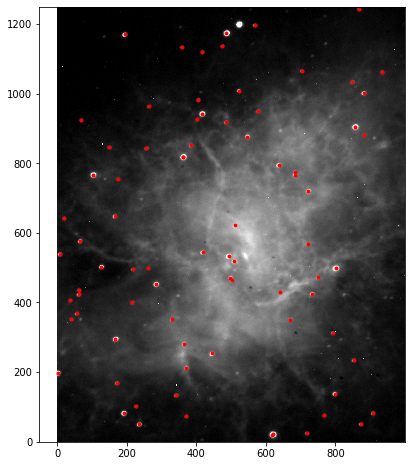

In [191]:
# Below I plot apertures surrounding each of the objects and estimate their flux using these circles
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  



 
showImage(data)
plt.scatter(positions[0:, 0], positions[0:, 1], marker = '.', color = 'r')

In [211]:

apertures = CircularAperture(positions, r=7.)  
phot_table = aperture_photometry(data, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)  
ascii.write(phot_table, 'phot_values.csv', format='csv', fast_writer=False)  


 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 619.14506  20.21511    6296253.6
  2 621.20145 21.309047      6340958
  3 717.07025 25.053934    83933.248
  4 236.15391 50.425259    1089631.3
  5 872.57097 51.174302    163028.17
  6 370.80589 73.712845    65134.192
  7 767.33217 75.662708    86001.135
  8 191.94031 82.491423    2037341.7
  9 907.42674 82.618478    206404.97
 10 226.38687 102.21312    73179.025
...       ...       ...          ...
 71 848.88624  1033.779    273676.43
 72 934.42107 1063.1129    142785.25
 73 703.13092 1065.8874     165970.6
 74 417.74005 1121.0927    46590.439
 75 357.93867 1134.0729    63755.844
 76 475.57226 1138.3206    38549.589
 77 194.43866  1170.436    1190810.3
 78 486.95781 1174.0466    4982869.6
 79 567.86778 1197.1575    208662.73
 80 867.09947 1243.8652    75079.231
Length = 80 rows


In [212]:
appFluxs =  phot_table['aperture_sum']

__How many objects did you identify with DAOStarFinder? Look at your image.
Do you think that’s a reasonable number? What did you change to adjust the number of
stars detected? How many stars did you end up with?__

DOAStarFinder identified 116 objects using the bounds fwhm = 4 and sigma = 100* bkgd. Most of these objects were identified at the edges of the image and in the center where the overscan was before it was removed. That said, when creating a mask to remove these data is was necessary to trim a relatively large region ~10 pixels wide. I think 116 stars is somewhat large. This is especially because some of the obvious stars to the eye were left undected. To adjust the number of detected stars I increased the amount that that star had to deviate above the background in order to be counted. The first run of the function I used sigma = 3 and that returned ~600 stars. 

Doing this a second time having subtraceted more overscan fromt the fully reduced image causes DAOStarFinder to not get as many errors from the missed overscan pixels. There is some risk that I cut off some of dataful pixels in cutting a large region of overscan. 

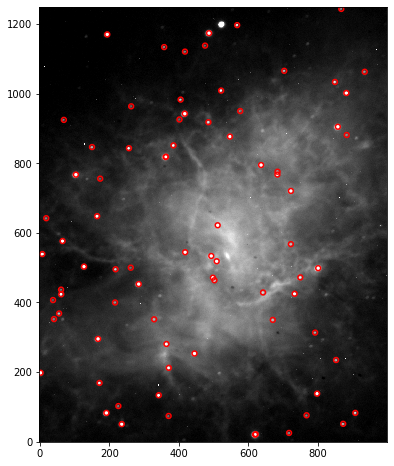

In [213]:
showImage(data)
apertures.plot(color='red', lw=1.5)

__Are you happy with your apertures? Why or why not? Save the list of sources
for comparison. Why did you choose the method (center, exact, subpixel) to solve the
square pixel/round aperture problem?__

Yes these apertures seem ok. For some of the objects they may be too large however for most of the objects, r = 10 seems to be the appropriate radius. I chose to use the default method = exact to get the highest precision estimate within the given aperture I specified. 

In [214]:
from photutils import CircularAnnulus

In [222]:
apertures = CircularAnnulus(positions, r_in = 7, r_out = 14)  
phot_table = aperture_photometry(data, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)  
ascii.write(phot_table, 'phot_values.csv', format='csv', fast_writer=False)  

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 619.14506  20.21511    1087783.7
  2 621.20145 21.309047    1044932.8
  3 717.07025 25.053934   -262625.06
  4 236.15391 50.425259   -90383.226
  5 872.57097 51.174302    -258266.8
  6 370.80589 73.712845   -169183.94
  7 767.33217 75.662708    -187090.5
  8 191.94031 82.491423     13742.63
  9 907.42674 82.618478      -201354
 10 226.38687 102.21312   -192438.24
...       ...       ...          ...
 71 848.88624  1033.779    159134.04
 72 934.42107 1063.1129   -5989.8662
 73 703.13092 1065.8874   -84234.321
 74 417.74005 1121.0927    -291768.5
 75 357.93867 1134.0729   -307665.87
 76 475.57226 1138.3206   -233027.05
 77 194.43866  1170.436   -218220.72
 78 486.95781 1174.0466    360118.35
 79 567.86778 1197.1575   -273448.04
 80 867.09947 1243.8652   -161452.34
Length = 80 rows


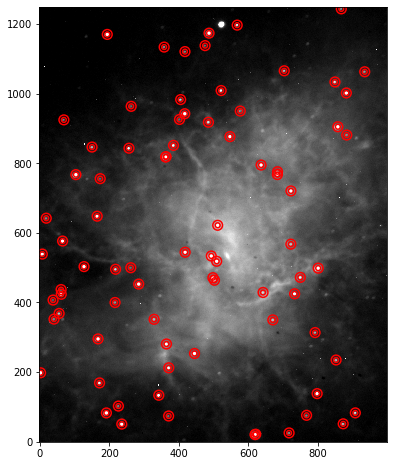

In [223]:
showImage(data)
apertures.plot(color='red', lw=1.5)

Text(1.5, 5700000, 'Annulus inner radius = 7, outer radius = 14')

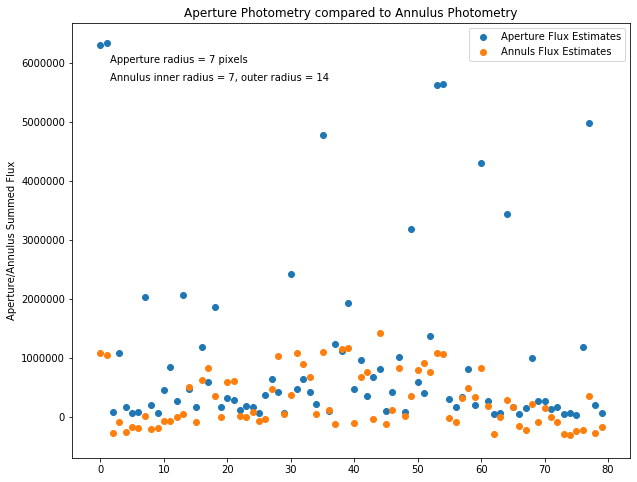

In [228]:
# Create a plot showing the difference between these two estimates of flux. 
x = np.arange(0, len(annFluxs), 1)

annFluxs = phot_table['aperture_sum']
plt.figure(figsize = (10, 8))
plt.scatter( x, appFluxs, label = 'Aperture Flux Estimates');
plt.scatter(x, annFluxs, label = 'Annuls Flux Estimates');
plt.title('Aperture Photometry compared to Annulus Photometry')
plt.legend()
plt.ylabel('Aperture/Annulus Summed Flux');
plt.savefig('appvsann.png')
plt.text(1.5, 6000000, 'Apperture radius = 7 pixels')
plt.text(1.5, 5700000, 'Annulus inner radius = 7, outer radius = 14')

268596.9557912787